Notes:

- Will train static y[:1000], then decompose and predict step wise simulation.

In [1]:
from vmdpy import VMD
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.layers import Conv1D, Dense, LSTM, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras import activations
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
import matplotlib.pyplot as plt
# need to create validation part of testing!

class vmd_lstm:

    def train_data(x_train, y_train, length=21):
        '''Train data generator. Can be many steps ahead forecast.
        '''
        data_gen = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            x_train,
            y_train,
            length=length,  # t-n to t
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=256
        )  # missing target length horizon (only manual setting)
        return data_gen
    
    def test_data(x_test, length=21):
        '''Test data should not leak target,
        y_test == np.zeros(len(x_test)).
        '''
        gen_day_ahead = tf.keras.preprocessing.sequence.TimeseriesGenerator(
            x_test,
            np.zeros(len(x_test)),
            length=21,  # t-n to t
            sampling_rate=1,
            stride=1,  # gap by n-days
            start_index=0,  # ex. start on monday
            end_index=None,
            shuffle=False,
            reverse=False,
            batch_size=1
        )  # missing target length horizon (only manual setting)

        return gen_day_ahead
    
    def lstm(input_data, epochs=500, learning_rate=1e-3):
        '''Custom model LSTM-DNN.
        Returns keras.models.Sequential()
        formula and prints log(loss) plot for reference.
        '''
        model = keras.models.Sequential()
        # model.add(keras.layers.Input(shape=(21, 13)))
        # Can have CNN layer if we have many IMFs (test)
        model.add(LSTM(128, return_sequences=True, activation='relu'))
        model.add(LSTM(64, return_sequences=False, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(1))

        model.compile(optimizer=Adam(learning_rate=learning_rate), loss=['mse'])
        a = model.fit(input_data, shuffle=False, epochs=epochs, workers=-1, use_multiprocessing=True)
        plt.figure(figsize=(14,8))
        plt.plot(np.log1p(a.history['loss']))
        plt.title("log(Loss history)")
        plt.grid()

        return model
    
    def vmd(input_data, n_modes=13, alpha=200, tol=1e-20, plot=True):
        '''Input data and decompose it to n-modes.
        Function to be used in sensitivity analysis in pre-processing part.
        Returns decomposed_data , y_hat, omega.
        Use plot=False when grid searching for parameters.
        '''
        # Params  
        alpha = alpha  # quadratic penalty, high alpha == bias (sensitivity analysis)
        tau = 0.  # noise-tolerance (no strict fidelity enforcement)  
        K = n_modes  # modes count (sensitivity analysis)
        DC = 0  # no DC part imposed  
        init = 1  # initialize omegas uniformly  
        tol = tol  

        # VMD 
        modes, u_hat, omega = VMD(input_data, alpha, tau, K, DC, init, tol)  

        # Reconstruct data
        a = input_data
        reconstruct = np.sum(pd.DataFrame(modes))  # additive components; shape==(503, 13)
        rmse = np.sqrt(1/len(a) * np.sum(np.square(a-reconstruct)))
        mape = np.mean(np.abs(reconstruct/a-1))
    
        if plot == True:
            # Visualize decomposed modes
            plt.figure(figsize=(14,8))
            plt.subplot(2,1,1)
            plt.plot(input_data)
            plt.title('Original signal')
            plt.subplot(2,1,2)
            plt.plot(modes.T)
            plt.title('Decomposed modes')
            plt.legend(['Mode %d'%m_i for m_i in range(modes.shape[0])])
            plt.tight_layout()

            plt.figure(figsize=(14,8))
            plt.plot(y-reconstruct)
            plt.title("Reconstruction error")
            plt.figure(figsize=(14,8))
            plt.hist(y-reconstruct, bins='fd')

        return modes.T, rmse, mape
    
    def predict_test(x_test, len=21):
        '''x_test = Test data generated 
        from tf.TimeseriesGenerator()
        '''
        offset_length = 100 - len
        y_act = pd.Series(y[-offset_length:])  # uses global y
        y_pred = model.predict(x_test)  # weird format
        y_pred = pd.Series(y_pred.T[0])
        plt.figure(figsize=(32,8))
        plt.plot(y_act, label='actual')
        plt.plot(y_pred, c='r', label='pred')
        plt.legend()
        plt.grid()

        return y_pred, y_act

    def predict_train(x_train, len=21):
        '''x_train = Train data generated 
        from tf.TimeseriesGenerator()
        '''
        offset_length = 1000 - len
        y_act = pd.Series(y[:1000]).shift(-21)
        y_pred = model.predict(data_gen)
        plt.figure(figsize=(32,8))
        plt.plot(y_act, label='actual')
        plt.plot(y_pred, c='r', label='pred')
        plt.legend()
        plt.grid()
        
        return y_pred, y_act

Structure of tf.TimeseriesGenerator ex. (array([[0, 1, 2, 3, 4]]), array([5]))

Conclution: If we dont use pipeline with pre-processing -> modeling -> testing at each step, we are doing VMD wrong!

**Doing all dataset to IMFs and then slicing for test set is leaking the target into test set!**

Redo and organize:
- Pre-process/model/test unseen per steps and collect in for loop
- Organize all into one big for loop that will collect steps of predictions.

In [2]:
### Pipeline simulation

import yfinance as yf

# Download and prepare financial data
spy_df = yf.download(tickers = "SPY",  # list of tickers
                period = "5y",         # time period
                interval = "1d",       # trading interval
                prepost = False,       # download pre/post market hours data?
                repair = True)
spy_pct = np.log1p(spy_df["Adj Close"].pct_change().dropna())
spy_pct = np.array(spy_pct)

y_total = spy_pct


[*********************100%***********************]  1 of 1 completed


C:\Users\dminc\AppData\Local\Temp\ipykernel_16476\1405142006.py:110: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


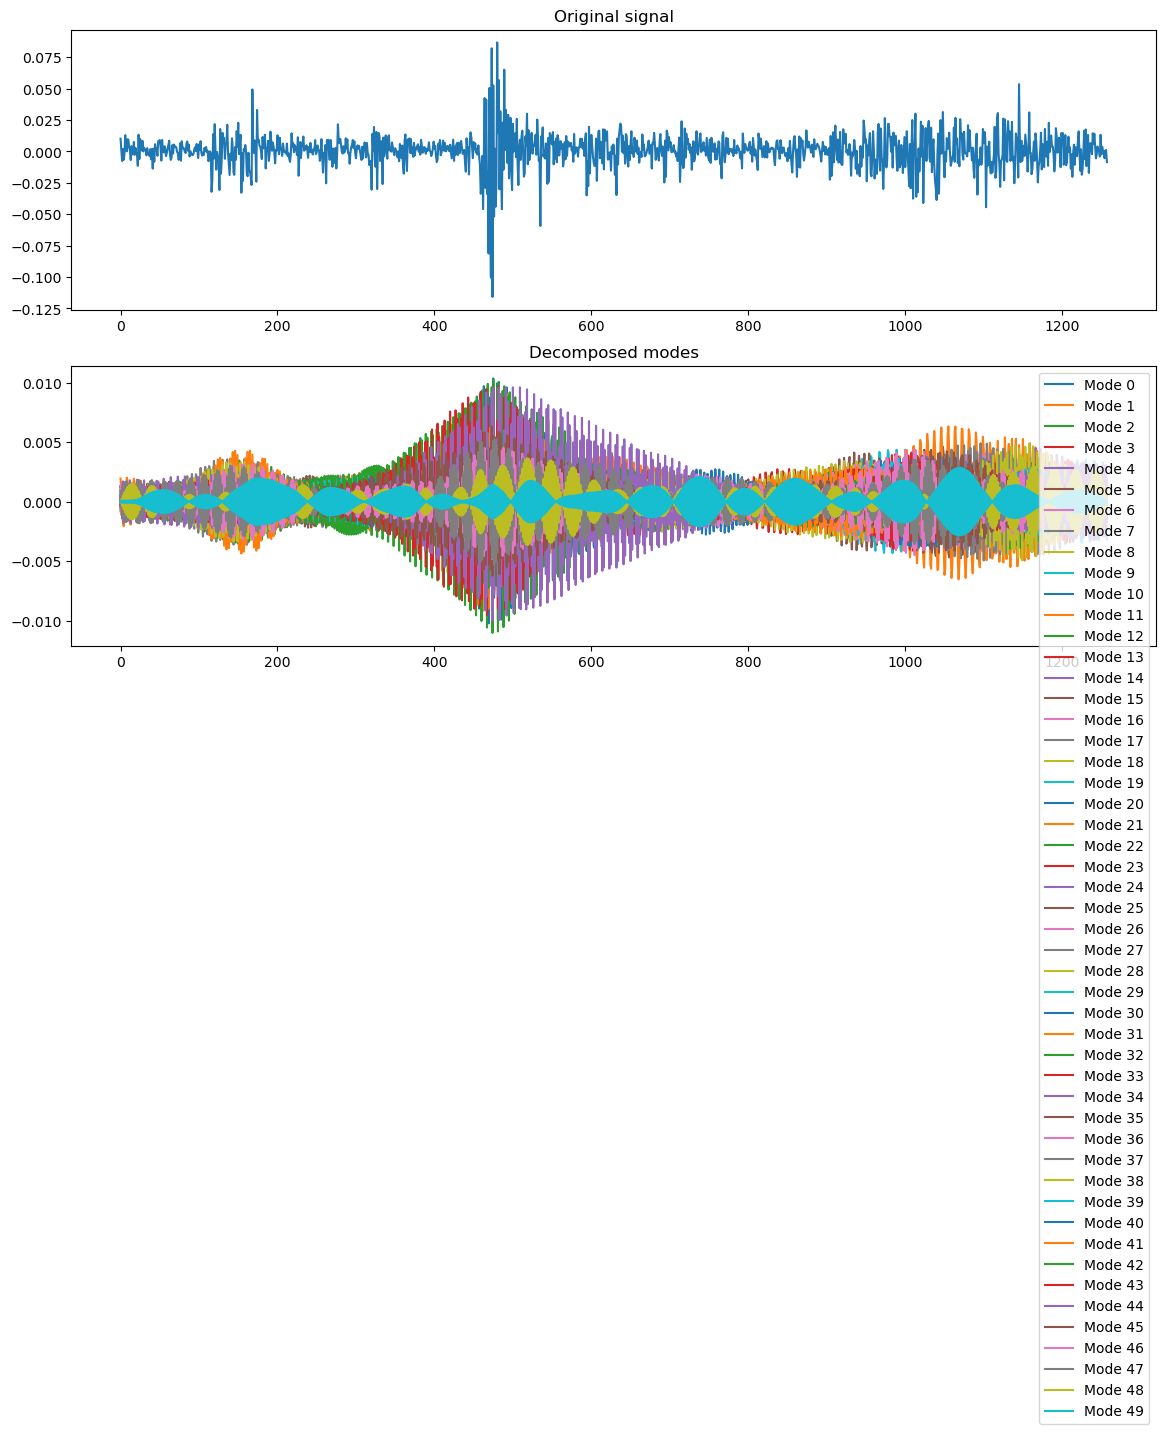

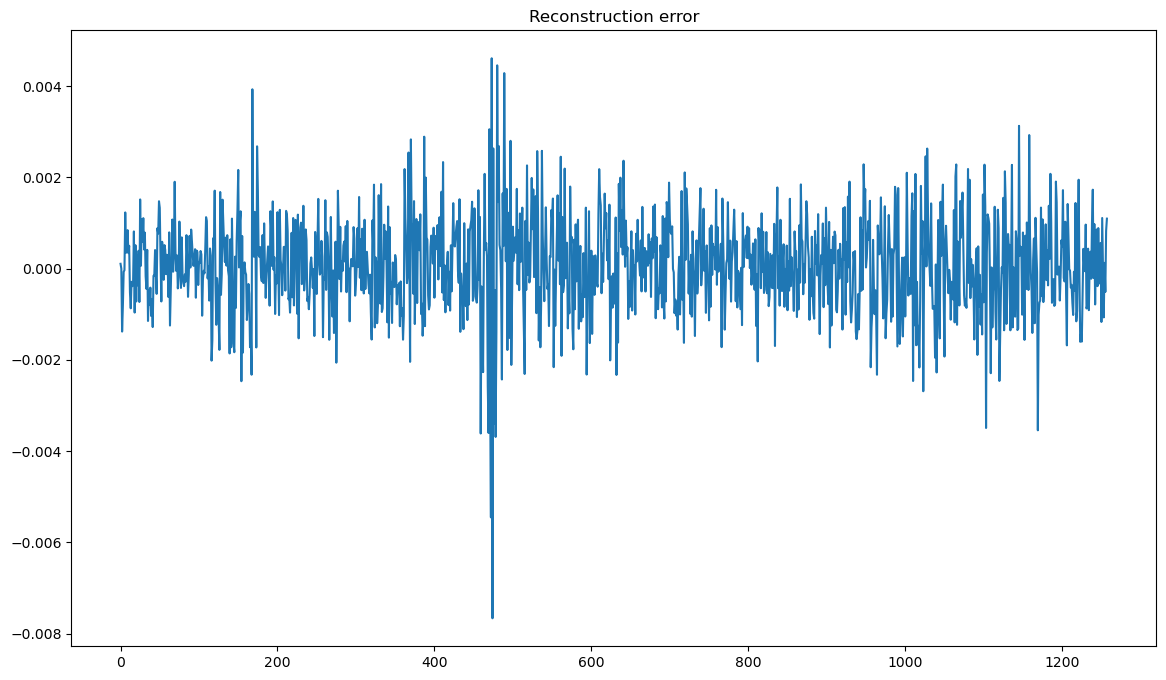

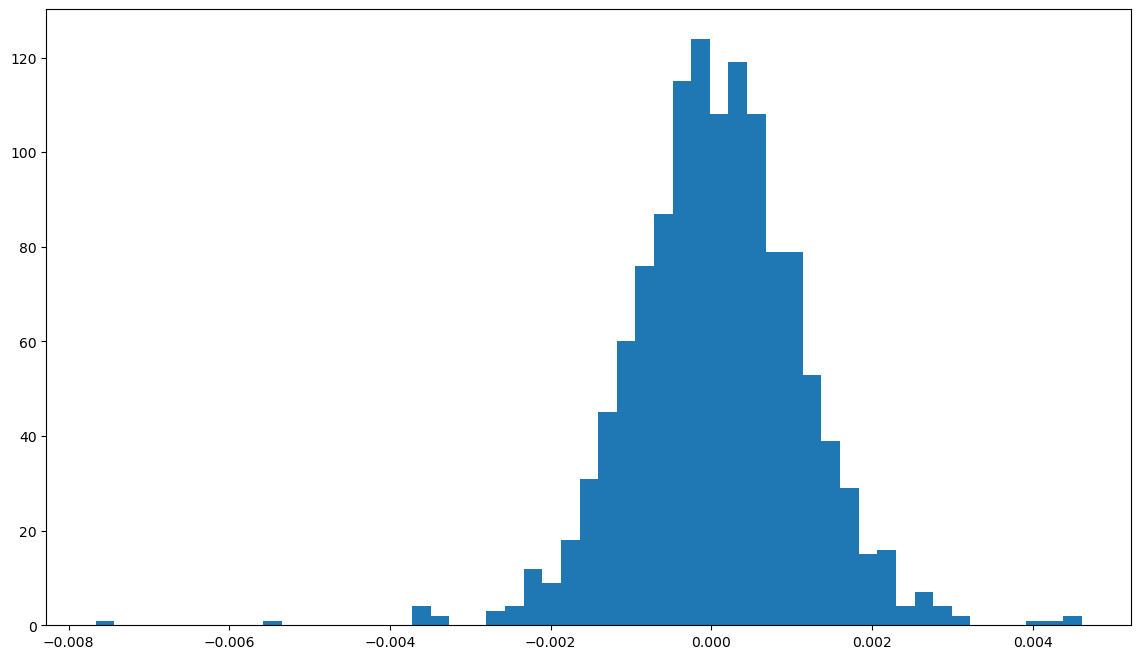

In [158]:
y = y_total
modes, _, _ = vmd_lstm.vmd(y, n_modes=50, alpha=15000, plot=True)

Epoch 1/800
4/4 [==============================] - 5s 87ms/step - loss: 1.7833e-04
Epoch 2/800
4/4 [==============================] - 0s 86ms/step - loss: 1.7839e-04
Epoch 3/800
4/4 [==============================] - 0s 95ms/step - loss: 1.7821e-04
Epoch 4/800
4/4 [==============================] - 0s 90ms/step - loss: 1.7811e-04
Epoch 5/800
4/4 [==============================] - 0s 94ms/step - loss: 1.7810e-04
Epoch 6/800
4/4 [==============================] - 0s 94ms/step - loss: 1.7805e-04
Epoch 7/800
4/4 [==============================] - 0s 88ms/step - loss: 1.7795e-04
Epoch 8/800
4/4 [==============================] - 0s 111ms/step - loss: 1.7793e-04
Epoch 9/800
4/4 [==============================] - 0s 98ms/step - loss: 1.7791e-04
Epoch 10/800
4/4 [==============================] - 0s 90ms/step - loss: 1.7785e-04
Epoch 11/800
4/4 [==============================] - 0s 108ms/step - loss: 1.7783e-04
Epoch 12/800
4/4 [==============================] - 0s 97ms/step - loss: 1.7780e-04

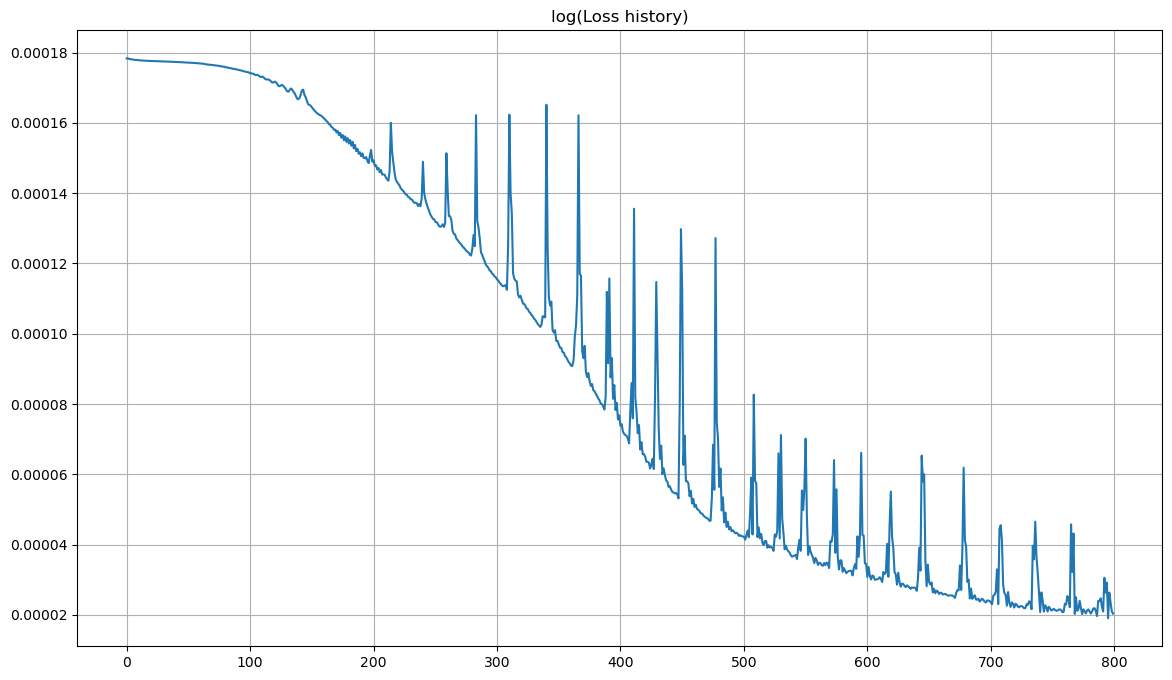

In [162]:
%%time

## Simulator
collect = []
index_end = list(range(1000, len(spy_pct), 2))
# index_start = list(range())
for i in index_end:
    # Prepare slice for vmd
    y = spy_pct[:i]

    # IMFs input data (vmd param search)
    modes, _, _ = vmd_lstm.vmd(y, n_modes=10, alpha=15000, plot=False)  # n_modes=K, alpha=alpha

    x_train, y_train = modes, y
    x_test = np.concatenate([modes[-21:], [np.zeros(50)]])
    data_gen = vmd_lstm.train_data(x_train, y_train)
    data_gen_dayahead = vmd_lstm.test_data(x_test)  # take y_total outside of the loop for comparison
    
    # Train (only initially)
    if i == 1000:
        model = vmd_lstm.lstm(data_gen, epochs=800, learning_rate=1e-4)

    # # Pred seen data (optional)
    # y_pred, y_act = vmd_lstm.predict_train(data_gen)

    # Pred unseen day ahead
    step_ahead = model.predict(data_gen_dayahead)  # this will pred t+1 ex. y[1001] on first iter
    collect.append([i, step_ahead])

In [163]:
collect_df = pd.DataFrame(collect)
collect_df.to_csv("simulator_collect.csv")  # currently every second day in order to meet VMD criteria of even decomposition

In [165]:
# Load collected
simulator_result = pd.read_csv("simulator_collect.csv")
simulator_result.y_index += 1  # this is double checked and it is correct!

Why dont we have 130th row as it is supposed to be? Is the generator faulty with np.zeros last row? or we just currently at the day that us even counting from 1000th index of the data..

In [167]:
simulator_result

,y_index,y_pred_sim
0,1001,0.009357
1,1003,-0.005264
2,1005,0.002065
3,1007,-0.033307
4,1009,-0.025520
...,...,...
124,1249,-0.000990
125,1251,0.011651
126,1253,0.001575
127,1255,0.000670


In [168]:
y_actual = pd.DataFrame(y_total)[1000:].reset_index()
y_actual.columns = ['y_index', 'y_actual']
y_actual

,y_index,y_actual
0,1000,-0.012530
1,1001,0.000411
2,1002,0.016014
3,1003,-0.000742
4,1004,-0.015067
...,...,...
253,1253,-0.000169
254,1254,-0.005472
255,1255,0.000777
256,1256,0.001043


In [169]:
concat = simulator_result.merge(y_actual, how="left", on='y_index')
concat

,y_index,y_pred_sim,y_actual
0,1001,0.009357,0.000411
1,1003,-0.005264,-0.000742
2,1005,0.002065,-0.027823
3,1007,-0.033307,-0.029388
4,1009,-0.025520,0.024946
...,...,...,...
124,1249,-0.000990,0.013195
125,1251,0.011651,0.003582
126,1253,0.001575,-0.000169
127,1255,0.000670,0.000777


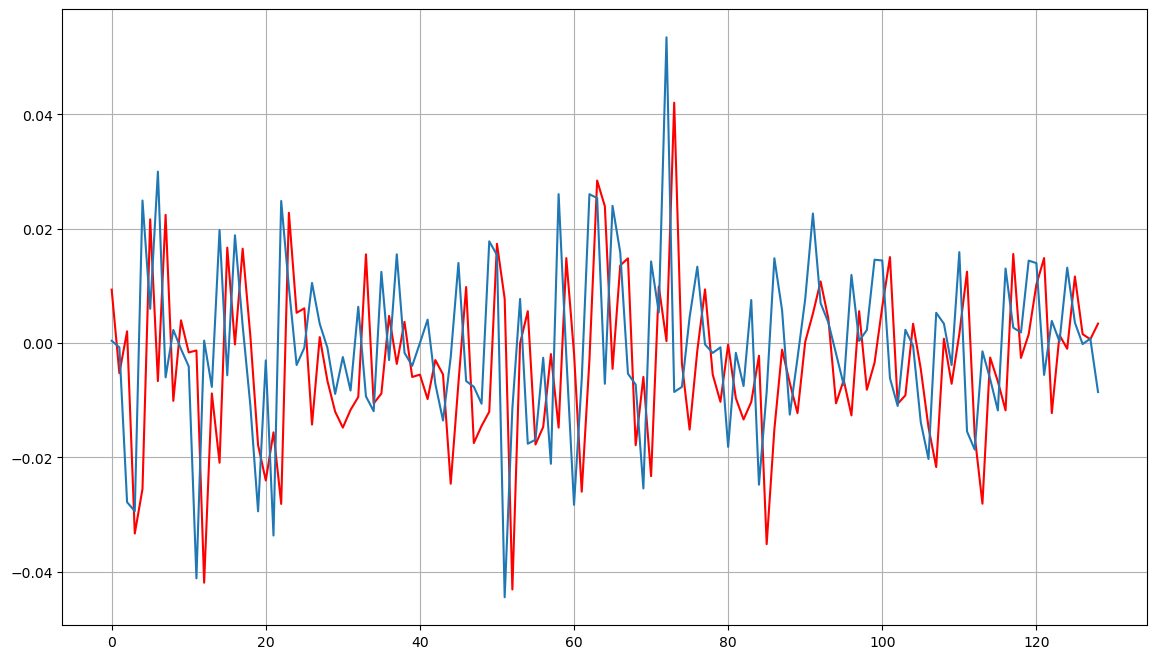

In [170]:
concat = simulator_result.merge(y_actual, on='y_index')
plt.figure(figsize=(14, 8))
plt.plot(concat.y_pred_sim, c='r')
plt.plot(concat.y_actual)
plt.grid()

Not sure how to organize y_pred/y_actual in this plot the current data is gapping by 2 because of VMD() condition that requires only even examples while decomposing

In [13]:
# Problem (decomposing odd amount of rows leads to one less row in modes dataset)
y_total = y_total[:1001]
modes = vmd_lstm.vmd(y_total, n_modes=29, alpha=50, plot=False)
display(pd.DataFrame(modes).shape)
display(pd.DataFrame(y_total).shape)

(1000, 29)

(1001, 1)

Note: Potential fix with odd number problem for decomposition can be shifting between first slice index y[0/1:n]